From the Riddler Classic problem stated in [Are You Hip Enough to Be Square](https://fivethirtyeight.com/features/are-you-hip-enough-to-be-square/):

>Recently, there was an issue with the production of foot-long rulers. It seems that each ruler was accidentally sliced at three random points along the ruler, resulting in four pieces. [&hellip;] On average, how long are the pieces that contain the 6-inch mark?

Generalize to rulers sliced into $n$ segments: the vector $[P_1, P_2, \ldots, P_n]$ of random lengths of the segments (measured in feet) follows the [flat Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution#Special_cases), i.e.,

\begin{equation*}
   [P_1, P_2, \ldots, P_n] \sim \text{Dir}(\mathbf{1}) ,
\end{equation*}

and $E[P_i] = \frac{1}{n}$ for all $i.$ 

A trick for solving the problem is to conceptually add an $n$-th slice at the half-foot mark (there is almost surely no physical slice at that point). Write $k$ for the number of random slices in the left half-ruler, and 

$$L = [L_1, L_2, \ldots, L_{k+1}]$$

for the vector of random lengths of the $k+1$ segments in the left half-ruler. Then the scaled vector $2 L$ follows a flat Dirichlet distribution, and 

$$E[L_i] = \frac{1}{2} \cdot \frac{1}{k+1} = \frac{1}{2(k+1)}$$

for $i = 1, 2, \ldots, k+1.$ Similarly, for the random lengths $R_j,$ $j = 1, 2, \ldots, n-k,$ of segments in the right half-ruler, $E[R_j] = \frac{1}{2(n-k)}.$ When the rightmost segment of the left half-ruler and the leftmost segment of the right half-ruler are "glued together" to produce the segment containing the midpoint of the entire ruler, the expected length is

\begin{align*}
   E[L_{k+1} + R_1] 
      &= E[L_{k+1}] + E[R_1] \\
      &= \frac{1}{2(k+1)} + \frac{1}{2(n-k)} \\
      &= \frac{(n-k)+(k+1)}{2(k+1)(n-k)} \\
      &= \frac{n+1}{2(k+1)(n-k)} \text{ feet}
\end{align*}

by linearity of the expectation operator $E[\cdot].$

For each of the $n-1$ random slices, the probability that the slice occurs to the left of the half-foot mark is .5, and the random number of physical slices in the left half-ruler is binomially distributed: the probability that $k$ of the $n-1$ physical slices are in the left half-ruler is $2^{1-n} {n-1 \choose k}.$ Taking all cases into account, the expected length of the segment containing the half-foot mark is

\begin{align*}
   \sum_{k=0}^{n-1} 2^{1-n} {n-1 \choose k} \frac{n+1}{2(k+1)(n-k)} 
      &= 2^{-n} \sum_{k=0}^{n-1}{n-1 \choose k} \frac{n+1}{(k+1)(n-k)} \\
      &= 2^{-n} \sum_{k=0}^{n-1}\frac{(n-1)!}{(n-k-1)!k!} \frac{n+1}{(k+1)(n-k)} \\
      &= 2^{-n} \sum_{k=0}^{n-1} \frac{(n+1)(n-1)!}{(n-k)!(k+1)!} \\
      &= 2^{-n} \sum_{k=0}^{n-1} \frac{(n+1)!}{n(n-k)!(k+1)!} \\
      &= 2^{-n} n^{-1} \sum_{k=0}^{n-1} {n+1 \choose k+1} \\
      &= 2^{-n} n^{-1} \sum_{k=1}^{n} {n+1 \choose k} \\
      &= 2^{-n} n^{-1} \left[ \sum_{k=0}^{n+1} {n+1 \choose k}
                              - {n+1 \choose 0}
                              - {n+1 \choose n+1}
                        \right]\\
      &= 2^{-n} n^{-1} (2^{n+1} - 1 - 1) \\
      &= \frac{2^{n+1} - 2}{2^{n} n} \\
      &= \frac{2^{n} - 1}{2^{n-1} n} \text{ feet}.
\end{align*}

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import mpmath as mp
import numpy as np
from numpy.random import dirichlet
from math import fsum
from IPython.display import Image, display


def expected_length(n):
    """
    Returns, for `n` segments`, expected length of segment containing .5.
    """
    with mp.workdps(100):
        # 100 digits of working precision
        result = mp.mpf(2**n - 1) / (2**(n-1) * n)
    return result


class RulerSample(object):
    """
    Wraps an array of randomly segmented, unit-length rulers.
    """
    def __init__(self, n_segments, n_samples=100000):
        self.rulers = dirichlet(np.ones(n_segments), n_samples)
        self.cumulative = np.cumsum(self.rulers, axis=1)
        self.cumulative[:,-1] = 1.0
        
    def indices(self, points):
        """
        Returns the indices of the segments containing `points`.
        """
        result = [np.searchsorted(c, points) for c in self.cumulative]
        return np.array(result)

    def lengths(self, points):
        """
        Returns the lengths of the segments containing `points`.
        """
        cols = self.indices(points)
        rows = np.empty_like(cols)
        rows[:] = np.arange(rows.shape[0])[:,None]
        return self.rulers[rows, cols]
    
    def mean_length(self, points):
        """
        Returns the means of the lengths of segments containing `points`.
        """
        return np.mean(self.lengths(points), axis=0)
    
    def mean_max_length(self):
        """
        Returns the mean of the maximum segment lengths of the rulers.
        """
        return np.mean(np.max(self.rulers, axis=1))
    
    def plot_mean_lengths(self, ax, points):
        """
        Adds a curve to given axes `ax`.
        
        For each point in strictly ascending `points` on the ruler, the
        mean length of segments containing that point is calculated. Then
        the mean length is plotted as a function of the point.
        """
        means = self.mean_length(points)
        ax.plot(points, means, label=str(len(self.rulers[0])), lw=3)


def plot_mean_lengths(samples, npoints=101):
    """
    Invoke the `plot_mean_lengths` method of each of the `samples`.
    
    A single plot containing one curve for each sample is generated. In
    each curve, the mean length of the containing segment is plotted for
    each of `npoints` equispaced points, ranging from 0 to 1 (inclusive).
    """
    fig, ax = plt.subplots()
    ax.set_xlabel('Point')
    ax.set_ylabel('Mean Length')
    ax.set_title('Mean Length of Segment Containing Point')
    points = np.linspace(0.0, 1.0, npoints)
    for s in samples:
        s.plot_mean_lengths(ax, points)
    ax.legend(loc='best', title='Segments', fontsize='small',
              title_fontsize='small')
    ax.grid()
    ax.set_ylim((ax.get_ylim()[0], 0.799))
    return fig, ax


samples = np.empty(11, dtype=object)
samples[2:] = [RulerSample(n) for n in range(2, 11)]

The expected length of the longest of $n$ segments, $P_{(n)},$ is 

\begin{equation*}
   E[P_{(n)}]
      = \frac{\mathcal{H}_n}{n},
\end{equation*}

where $\mathcal{H}_n = \frac{1}{1} + \frac{1}{2} + \cdots + \frac{1}{n}$ is the $n$-th harmonic number. With $n=2$ segments, it is always the longer of the segments, with expected length 

\begin{equation*}
   E[P_{(2)}] = \frac{\mathcal{H}_2}{2} 
              = \frac{\frac{1}{1} + \frac{1}{2}}{2} 
              = \frac{3}{4},
\end{equation*}

that contains the midpoint of the unit-length ruler. Using the formula derived above, with $n=2,$

\begin{equation*}
   \frac{2^{n} - 1}{2^{n-1} n} = \frac{2^{2} - 1}{2^{2-1} 2} = \frac{3}{4}.
\end{equation*}

**For each sample, check the mean length of the longest segments in the rulers:**

In [2]:
def harmonic(n):
    return fsum(1 / np.arange(n, 0, -1))

def check_mean_max(samples):
    form = '{:2d} {:6.4f} {:6.4f}'
    for k, sample in enumerate(samples[2:]):
        n = k + 2
        print(form.format(n, harmonic(n)/n, sample.mean_max_length()))
            
check_mean_max(samples)

 2 0.7500 0.7499
 3 0.6111 0.6117
 4 0.5208 0.5212
 5 0.4567 0.4567
 6 0.4083 0.4092
 7 0.3704 0.3707
 8 0.3397 0.3395
 9 0.3143 0.3144
10 0.2929 0.2928


**Verify that, for $n=2$ segments, the mean length the segment containing the half-foot mark is about 0.75:**

In [3]:
samples[2].mean_length([0.5])[0]

0.7499257226148652

**For each sample, compare the mean length of the segments containing the half-foot mark to the analytic expectation of the length:**

In [4]:
def check_expected(samples):
    form = '{:2d} {:6.4f} {:6.4f}'
    for n in range(2, 11):
        analytic = float(expected_length(n))
        observed = samples[n].mean_length([0.5])[0]
        print(form.format(n, analytic, observed))

check_expected(samples)   

 2 0.7500 0.7499
 3 0.5833 0.5839
 4 0.4688 0.4693
 5 0.3875 0.3878
 6 0.3281 0.3291
 7 0.2835 0.2835
 8 0.2490 0.2491
 9 0.2218 0.2220
10 0.1998 0.2000


**Plot**

We've just verified that the midpoint of each curve plotted below is close to the analytic expectation. Some additional sanity checks, eyeballing the plot below: 

- The curves are all symmetric about .5.
- When there are $n$ segments, the mean lengths of the segments containing 0 and 1 are approximately $1/n.$

**Hack:** The thin white lines atop the colored lines are the analytic expectations of segment lengths, calculated according to the formula [derived by Mark W. Girard](https://www.markwgirard.site/no-matter-how-you-slice-it-solution-to-riddler-14-august-2020/).

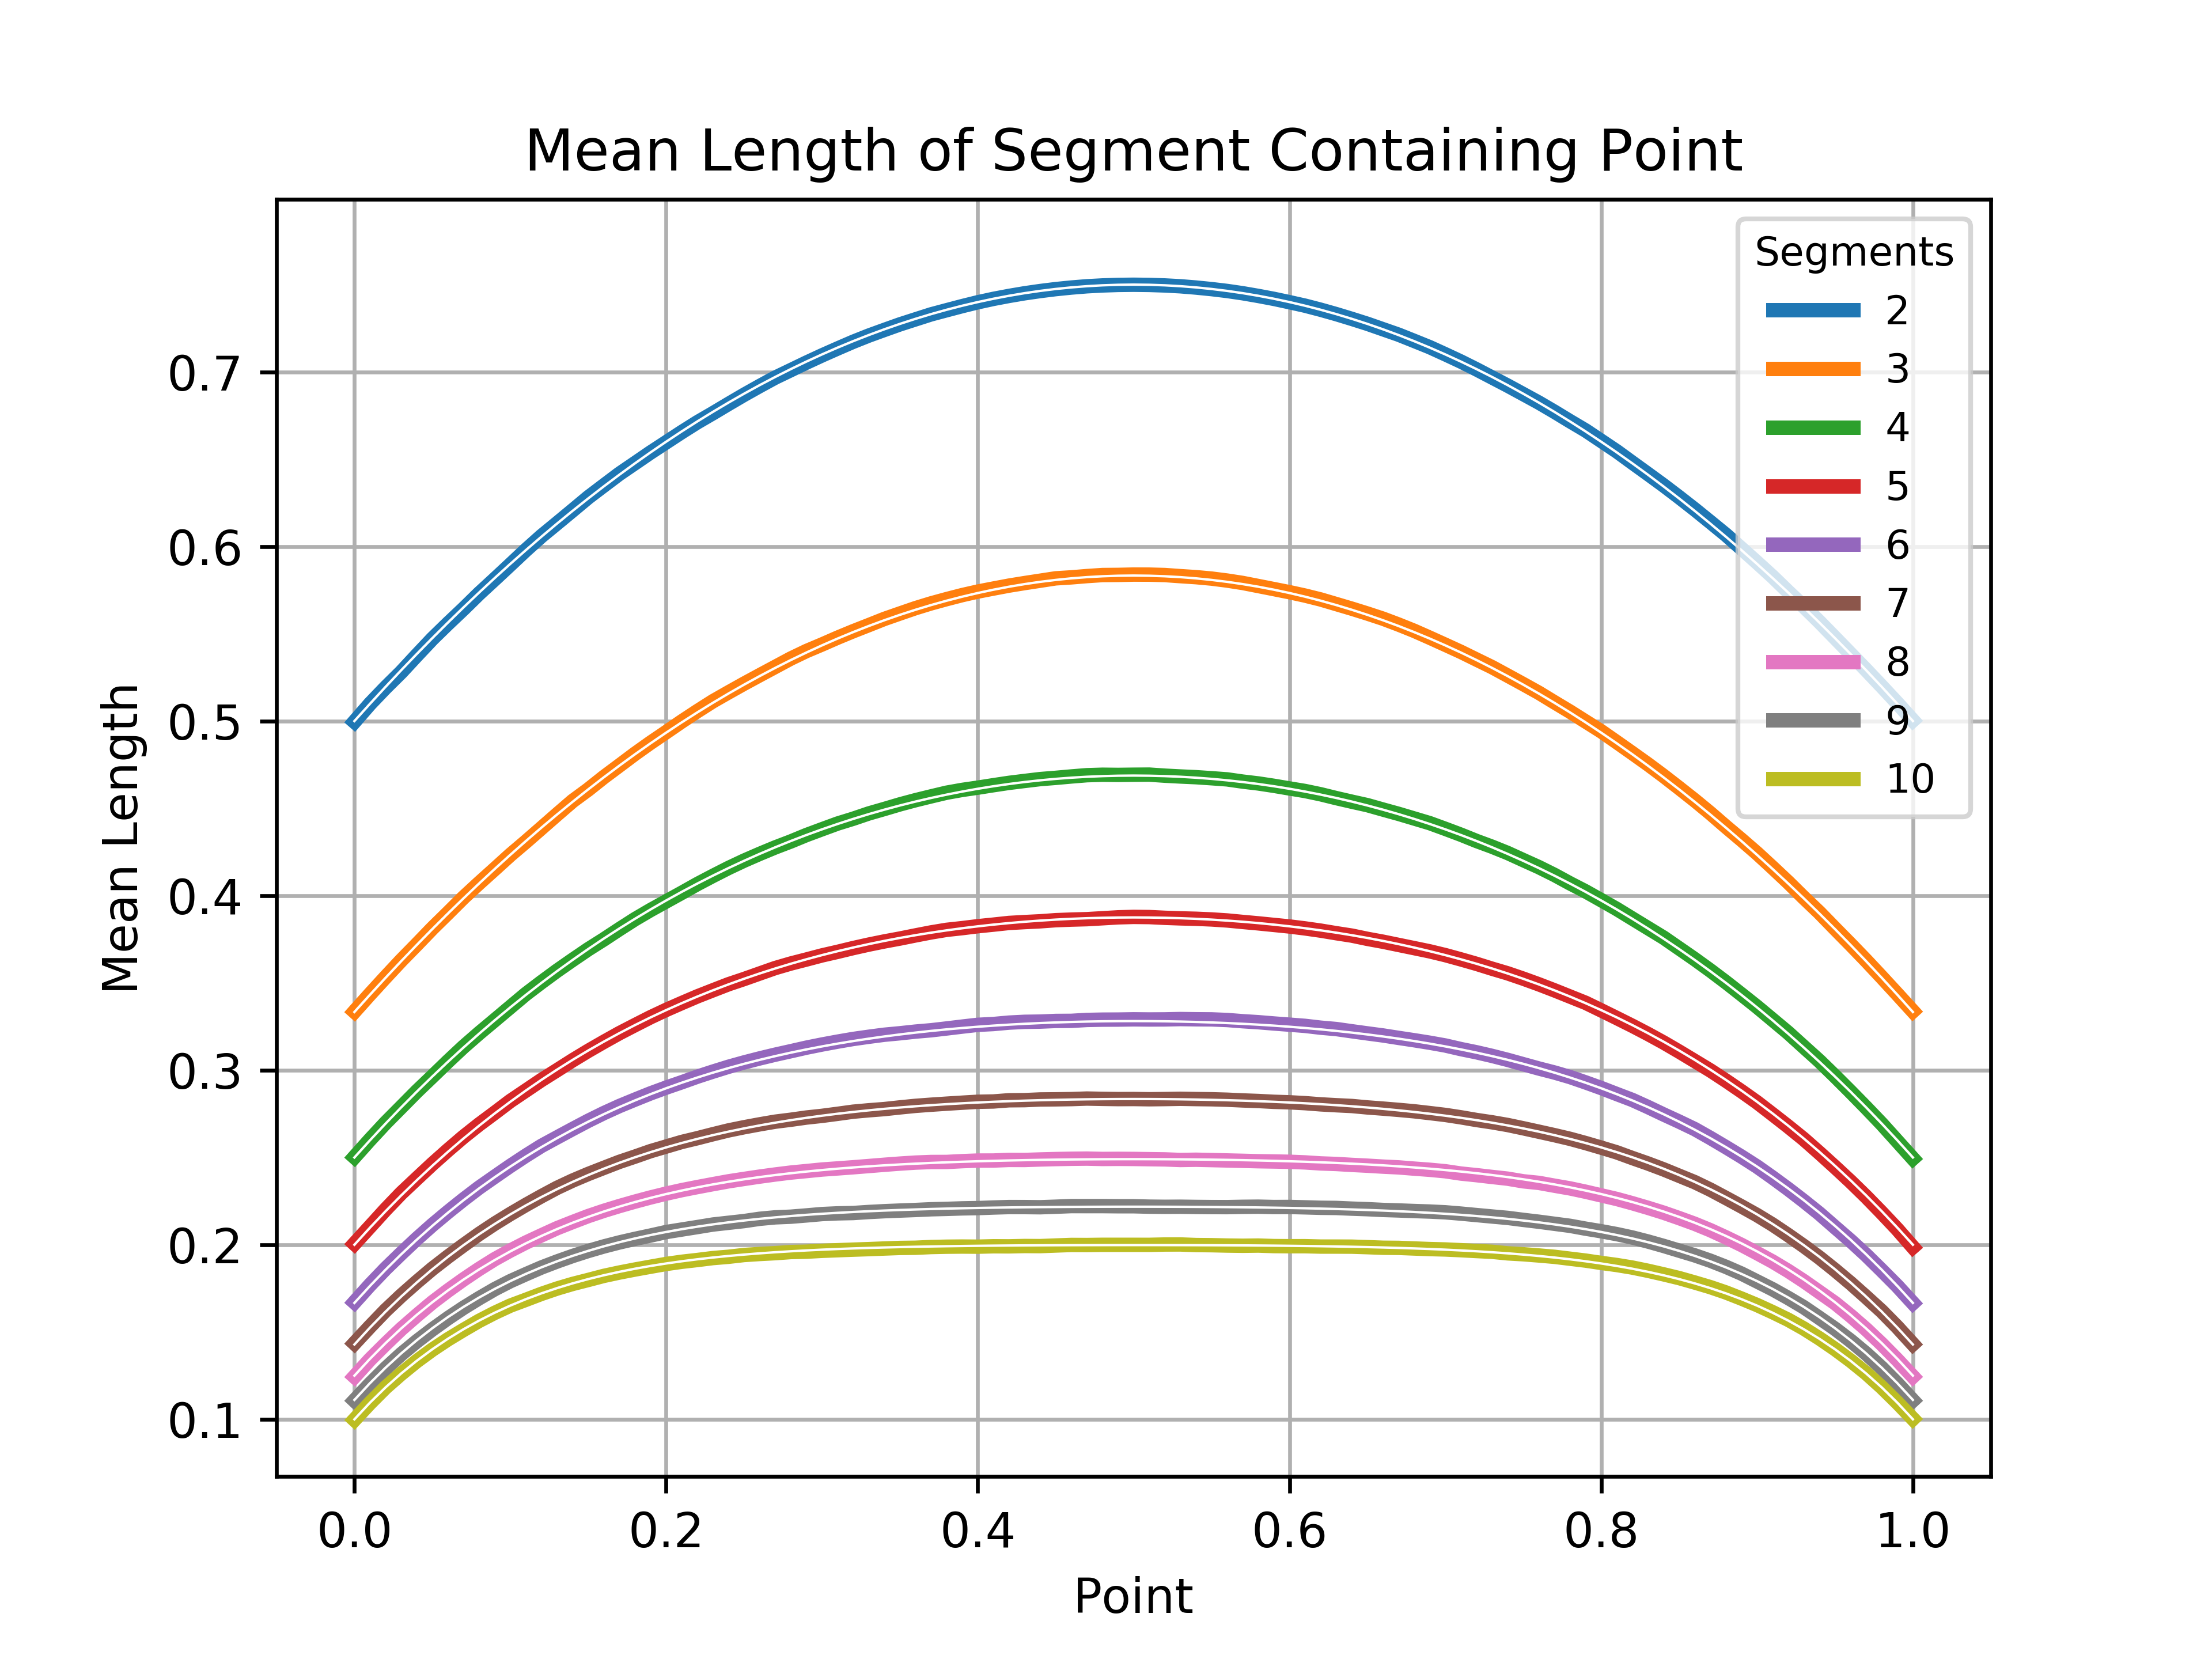

CPU times: user 8.53 s, sys: 1.41 s, total: 9.95 s
Wall time: 10.1 s


In [5]:
%%time

def plot_expectation(samples, ax, npoints=101):
    """
    For each of the `samples`, add expectations to the plot on axes `ax`.
    
    The formula for the expected length of the segment containing a given
    point comes from Mark W. Girard: 
    """
    def expectation(r, n):
        # Here r is the point (or array of points) that must be included
        # in the segment, and n is the number of physical slices.
        return (2 - (r**(n+1) + (1-r)**(n+1))) / (n+1)
    #
    points = np.linspace(0, 1, npoints)
    n_segments = np.array([len(s.rulers[0]) for s in samples])
    for n_seg in n_segments:
        ax.plot(points, expectation(points, n_seg-1), c='w', lw=0.5)


plt.interactive(False)
fig, ax = plot_mean_lengths(samples[2:])
plot_expectation(samples[2:], ax)
fig.savefig('BrokenRuler.png', dpi=600, pad_inches=0.01)
display(Image(filename='BrokenRuler.png'))